In [1]:
import numpy as np
import scipy
from activ import load_data
from activ.readfile import load_preprocessed, TrackTBIFile, encode
from activ.data_normalization import data_normalization
import pandas as pd
from sklearn import preprocessing
from collections import Counter
import h5py
from sklearn.utils import shuffle
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
rawdata = load_data()
rawdata_bm = rawdata.biomarkers
rawdata_oc = rawdata.outcomes
rawdata_id = rawdata.patient_ids

In [15]:
bm_shuffle, oc_shuffle, id_shuffle = shuffle(rawdata_bm, rawdata_oc, rawdata_id)

In [16]:
fname = '/Users/ahyeon/data/activ/rawdata_shuffled.h5'
TrackTBIFile.write(fname, bm_shuffle, oc_shuffle, biomarker_features = rawdata.biomarker_features, 
                   outcome_features=rawdata.outcome_features, patient_ids=id_shuffle)

In [3]:
def conf_alliter(size, predicted, actual):
    confalliter = []
    for j in range(50):
        conf = np.zeros((size,size))
        labs = list(map(int, actual[j][size-2]))
        preds = list(map(int, predicted[j][size-2]))
        for l, p in zip(labs, preds):
            conf[l,p] += 1
        confalliter.append(conf)
    return confalliter

def accuracy(mat):
    return mat.trace()/mat.sum()

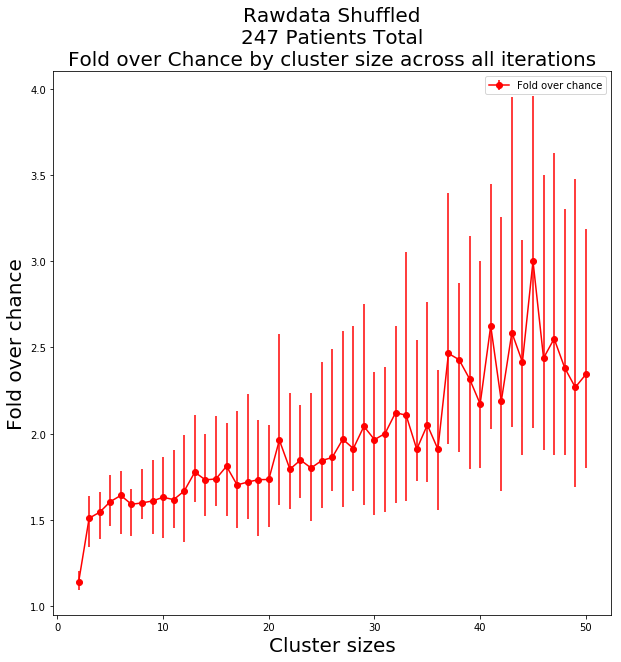

In [7]:
fname = '/Users/ahyeon/Desktop/activ misc/rawdata_shuffled_results.h5'
f = h5py.File(fname, 'r')

predictions = np.squeeze(f['score'][:], axis=1)
norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
cluster_sizes = f['cluster_sizes'][:]
labels = np.squeeze(f['clusters'][:], axis=1)
fold_over_chance = np.zeros((len(cluster_sizes), 50))
raw_acc = np.zeros((len(cluster_sizes), 50))
normalized_acc = np.zeros((len(cluster_sizes), 50))
for jj,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [float(x/y) for x, y in zip(acc, norm_acc)]
    fold_over_chance[jj,:] = foc
    raw_acc[jj,:] = acc
    normalized_acc[jj,:] = norm_acc


plt.rcParams["figure.figsize"] = [10,10]
cmap = plt.get_cmap("tab10")
lower = np.asarray([np.percentile(fold_over_chance[i,:], 25) for i in range(49)])
upper = np.asarray([np.percentile(fold_over_chance[i,:], 75) for i in range(49)])
med = np.median(fold_over_chance, axis=1)
raw_med = np.median(raw_acc, axis=1)
raw_lower = [np.percentile(raw_acc[i,:], 25) for i in range(49)]
raw_upper = [np.percentile(raw_acc[i,:], 75) for i in range(49)]
norm_med = np.median(normalized_acc, axis=1)
norm_lower = [np.percentile(normalized_acc[i,:], 25) for i in range(49)]
norm_upper = [np.percentile(normalized_acc[i,:], 75) for i in range(49)]
yerr = upper-lower
rel_iqr = yerr/med

plt.errorbar(cluster_sizes, med, yerr=[med-lower,upper-med], color = 'red',fmt='-o', label='Fold over chance')


plt.title("Rawdata Shuffled\n247 Patients Total\nFold over Chance by cluster size across all iterations", fontsize=20)
plt.xlabel("Cluster sizes", fontsize=20)
plt.ylabel("Fold over chance", fontsize=20)
plt.legend()
plt.savefig('/Users/ahyeon/Desktop/activ misc/raw_shuffled_foc.pdf')

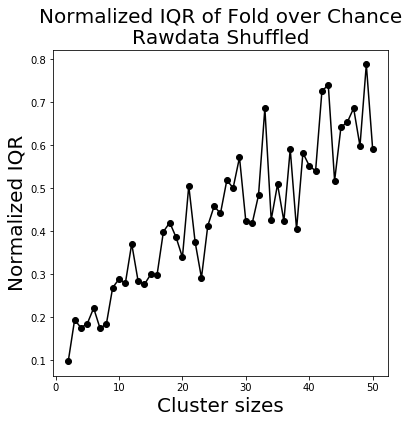

In [8]:
plt.figure(figsize=(6,6))
plt.plot(cluster_sizes, rel_iqr, '-o', color='black')
plt.title("Normalized IQR of Fold over Chance\nRawdata Shuffled", fontsize=20)
plt.xlabel("Cluster sizes", fontsize=20)
plt.ylabel("Normalized IQR", fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/IQR_raw_shuffled.pdf')

/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


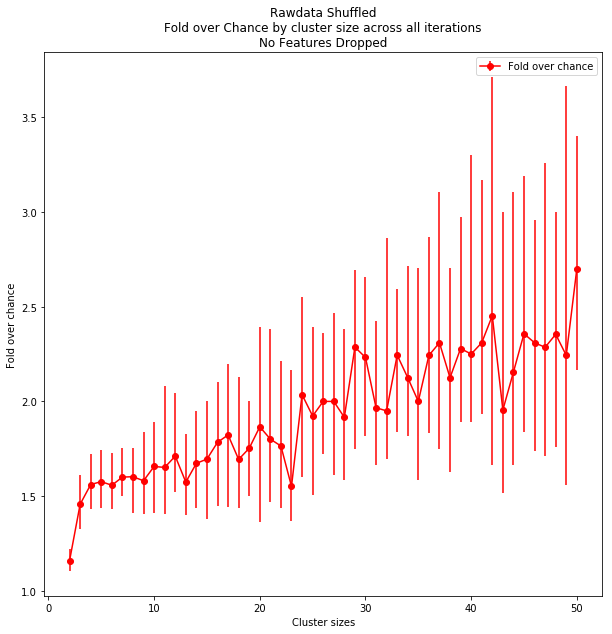

In [6]:
fname = '/Users/ahyeon/Desktop/activ misc/rawdata_shuffled_results_2.h5'
f = h5py.File(fname, 'r')

predictions = np.squeeze(f['score'][:], axis=1)
norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
cluster_sizes = f['cluster_sizes'][:]
labels = np.squeeze(f['clusters'][:], axis=1)
fold_over_chance = np.zeros((len(cluster_sizes), 50))
raw_acc = np.zeros((len(cluster_sizes), 50))
normalized_acc = np.zeros((len(cluster_sizes), 50))
for jj,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [float(x/y) for x, y in zip(acc, norm_acc)]
    fold_over_chance[jj,:] = foc
    raw_acc[jj,:] = acc
    normalized_acc[jj,:] = norm_acc


plt.rcParams["figure.figsize"] = [10,10]
cmap = plt.get_cmap("tab10")
lower = np.asarray([np.percentile(fold_over_chance[i,:], 25) for i in range(49)])
upper = np.asarray([np.percentile(fold_over_chance[i,:], 75) for i in range(49)])
med = np.median(fold_over_chance, axis=1)
raw_med = np.median(raw_acc, axis=1)
raw_lower = [np.percentile(raw_acc[i,:], 25) for i in range(49)]
raw_upper = [np.percentile(raw_acc[i,:], 75) for i in range(49)]
norm_med = np.median(normalized_acc, axis=1)
norm_lower = [np.percentile(normalized_acc[i,:], 25) for i in range(49)]
norm_upper = [np.percentile(normalized_acc[i,:], 75) for i in range(49)]
yerr = upper-lower

plt.errorbar(cluster_sizes, med, yerr=[med-lower,upper-med], color = 'red',fmt='-o', label='Fold over chance')


plt.title("Rawdata Shuffled\nFold over Chance by cluster size across all iterations\nNo Features Dropped")
plt.xlabel("Cluster sizes")
plt.ylabel("Fold over chance")
plt.legend()
plt.savefig('/Users/ahyeon/Desktop/activ misc/raw_shuffled_foc_2.pdf')

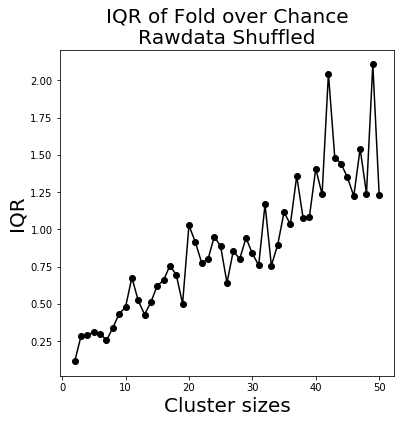

In [7]:
plt.figure(figsize=(6,6))
plt.plot(cluster_sizes, yerr, '-o', color='black')
plt.title("IQR of Fold over Chance\nRawdata Shuffled", fontsize=20)
plt.xlabel("Cluster sizes", fontsize=20)
plt.ylabel("IQR", fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/raw_shuffled_iqr_2.pdf')